In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

import time
from tqdm import tqdm
import matplotlib.pyplot as plt

from hopnet.utils.dataset import PreloadedDataset
from hopnet.utils.train import train_reconstruct
from hopnet.utils.transforms import mask_center_column, mask_center_row
from hopnet.utils.eval import evaluate_noise, evaluate_mask
from hopnet.activations import FastHopfieldActivation, StochasticHopfieldActivation
from hopnet.energies import ErrorEnergy, LyapunovEnergy
from hopnet.models.hopfieldnet import HopfieldNet

c:\Users\Joe\anaconda3\envs\ml-env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
DATA_RATIO = 0.0015 # portion of dataset to use, largest that works so far is 0.002. 

transform = transforms.Compose([
    transforms.ToTensor(),
    FastHopfieldActivation(prefer=-1), # set images to -1 or 1
])

dataset = datasets.MNIST(root="datasets/", train=True, transform=transform, download=True)
# reduce dataset size
# dataset = torch.utils.data.Subset(dataset, range(int(len(dataset) * DATA_RATIO)))
dataset = torch.utils.data.Subset(dataset, range(90))

train_dataset = PreloadedDataset.from_dataset(dataset, transforms.ToTensor(), device)
INPUT_SHAPE = train_dataset[0][0].shape
NUM_CLASSES = 10
time.sleep(0.1)
print(f'INPUT_SHAPE: {INPUT_SHAPE}')
print(f'Loaded MNIST dataset with {len(train_dataset)} training samples')#and {len(val_dataset)} validation samples')


INPUT_SHAPE: torch.Size([1, 28, 28])
Loaded MNIST dataset with 90 training samples


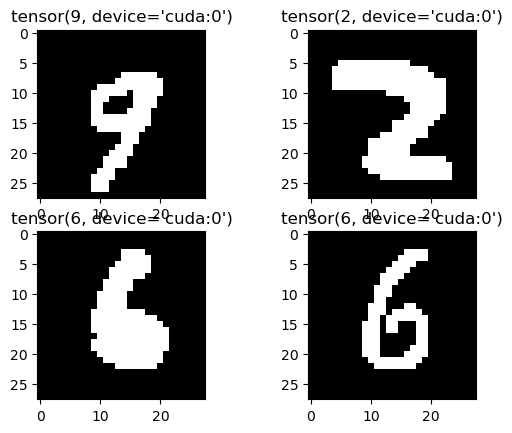

In [4]:
# Show 4 random images from the training dataset in grid
fig, ax = plt.subplots(2, 2)
for i in range(2):
    for j in range(2):
        idx = torch.randint(0, len(train_dataset), (1,)).item()
        image = train_dataset[idx][0].squeeze().cpu()
        ax[i, j].imshow(image, cmap="gray")
        ax[i, j].set_title(train_dataset[idx][1])
plt.show()

In [7]:
# Hebbian Learning
torch.manual_seed(42)
MODEL_NAME = "mnist_hopfield_error"
MODEL_DIR = "out/weights"
LOG_DIR = "out/logs"
size = 1
for dim in INPUT_SHAPE:
    size *= dim

# Specify your energy function
energy_fn = ErrorEnergy(actv_fn=torch.tanh)
# energy_fn = LyapunovEnergy()

# Specify your activation function
actv_fn = FastHopfieldActivation(prefer=-1)
# actv_fn = StochasticHopfieldActivation(temperature=1.0)

# Initialise model
model = HopfieldNet(size, energy_fn, actv_fn, bias=True, steps=10).to(device)
step = 0

In [8]:
# Good parameters for ErrorEnergy (max 90 images)
LR = 6e-4
BATCH_SIZE=16 # 8000 * DATA_RATIO seems effective
epochs = 3000
optimiser = optim.AdamW(model.parameters(), lr=LR)
SAVE_MODEL = True

# scheduler = ReduceLROnPlateau(optimiser, mode='min', min_lr=3e-9, factor=0.75, patience=5, verbose=True)
energy, loss, step = train_reconstruct(model, 
                             train_dataset, 
                             optimiser, 
                             MODEL_NAME, 
                             epochs, 
                            #  scheduler, 
                             mode='energy',
                             flatten=True, 
                             step=step, 
                             batch_size=BATCH_SIZE, 
                             model_dir=MODEL_DIR,
                             save_model=SAVE_MODEL,
                             untrain_after=10,
                             untrain_const=5.0,
                             eval_loss_every=100,
                             device=device)

FileNotFoundError: [Errno 2] No such file or directory: 'out/weights/mnist_hopfield_error.pt'

In [9]:
# load best model
model.load_state_dict(torch.load(f'{MODEL_DIR}/{MODEL_NAME}.pth'))

<All keys matched successfully>

In [ ]:
# Good parameters for LyapunovEnergy (max 90 images)
LR = 6e-3
BATCH_SIZE=8 # 8000 * DATA_RATIO seems effective
epochs = 1000
optimiser = optim.AdamW(model.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimiser, mode='min', min_lr=3e-9, factor=0.75, patience=5, verbose=True)

MODEL_DIR = 'models/weights'
energy, loss, step = train_reconstruct(model, 
                             train_dataset, 
                             optimiser, 
                             model_name, 
                             epochs, 
                            #  scheduler, 
                             mode='gardiner',
                             flatten=True, 
                             step=step, 
                             batch_size=BATCH_SIZE, 
                             model_dir='models/weights',
                             save_model=True,
                            #  untrain_after=10,
                             untrain_const=5.0,
                             validate_every=10,
                             device=device)

model.load_state_dict(torch.load(f'{model_dir}/{model_name}.pth'))
print(f'final (best) loss: {evaluate_mask(model, train_dataset, batch_size=1, loss_fn=F.l1_loss, flatten=True, device=device)}')

final (best) loss: 45.39259259259259


In [ ]:
print(f"Final energy: {energy[-1]} - Final loss: {loss[-1]}")
# loss > 50 is poor
# loss > 40 is average
# loss <= 40 is good

Final energy: -7078.546875 - Final loss: 30.64444351196289


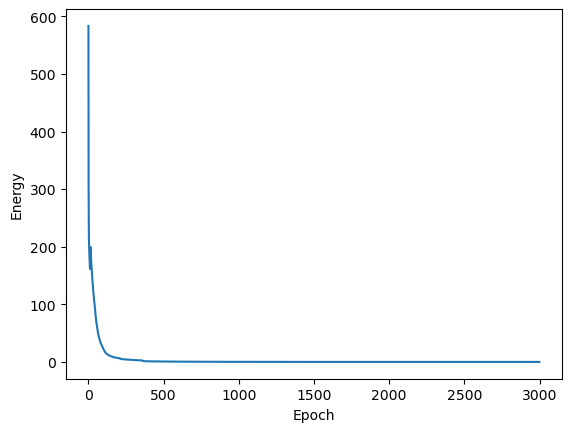

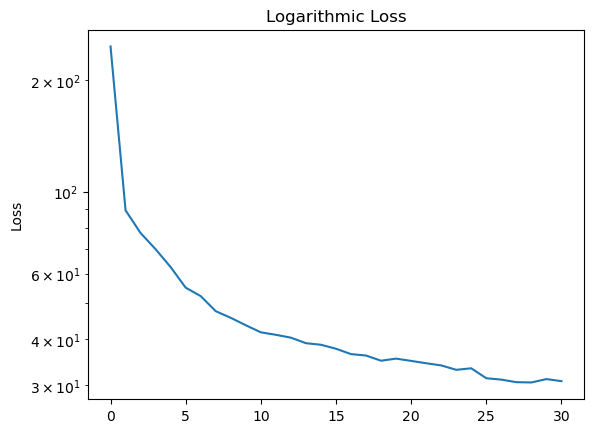

In [10]:
# plot energy over epochs
plt.plot(energy)
# plt.yscale("log")
# plt.title("Logarithmic Energy")
plt.xlabel("Epoch")
plt.ylabel("Energy")
plt.show()

plt.plot(loss)
plt.yscale("log")
plt.title("Logarithmic Loss")
plt.ylabel("Loss")
plt.show()


c:\Users\Joe\anaconda3\envs\ml-env\lib\site-packages\ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


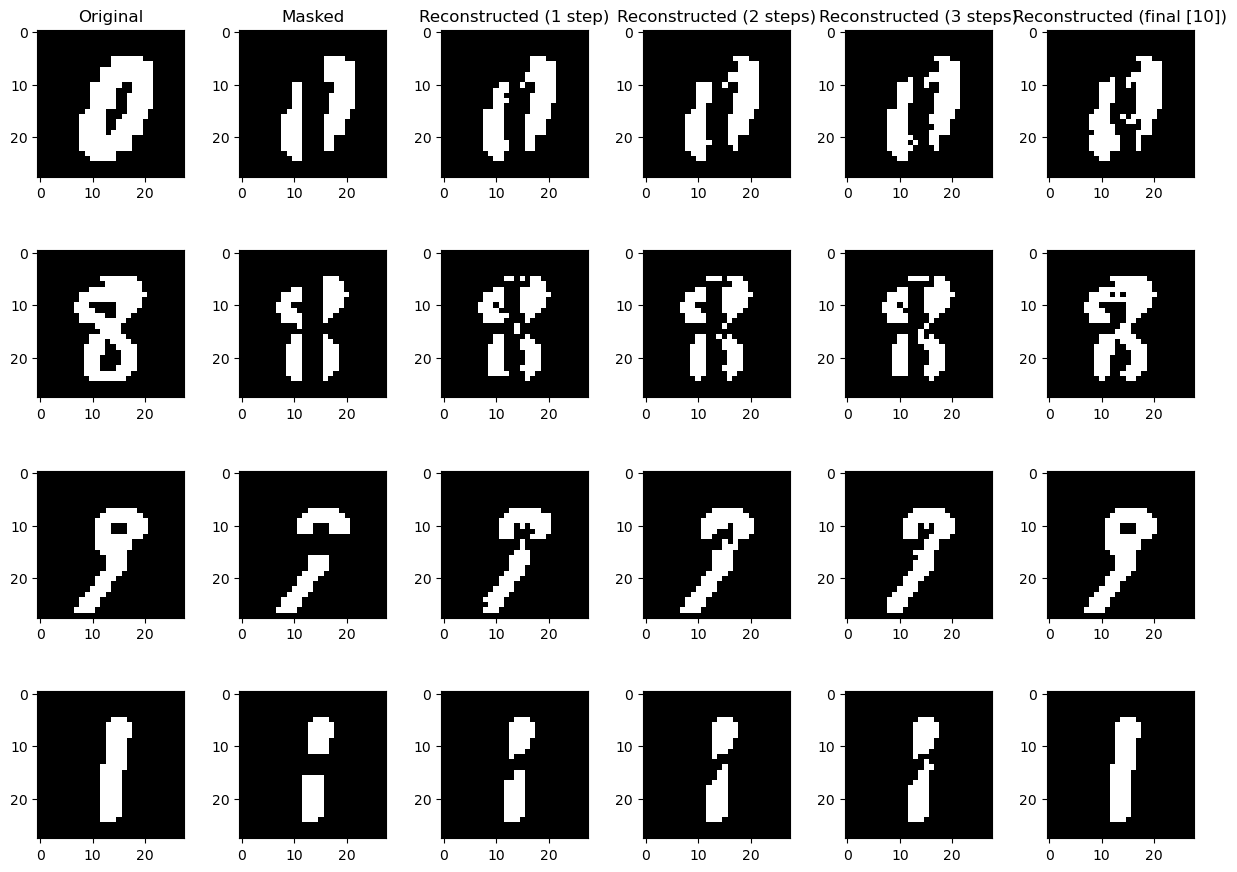

In [13]:
# Show 4 examples of original, masked and reconstructed images, with extra spacing between subplots
steps = (1, 2, 3)
width = 0.2
length = 4
if len(train_dataset) < 4:
    length = len(train_dataset)

# Randomly select 4 images from the training dataset
idxs = []
while len(idxs) < length:
    idx = torch.randint(0, len(train_dataset), (1,)).item()
    if idx not in idxs:
        idxs.append(idx)

fig, ax = plt.subplots(4, 6)
for i in range(length):
    original = train_dataset[idxs[i]][0].squeeze()
    if i < 2:
        masked = mask_center_column(original, width)
    else:
        masked = mask_center_row(original, width)
    masked = torch.tensor(masked)
    reconstructed_1 = model(masked.view(-1), steps=steps[0]).view(INPUT_SHAPE)
    reconstructed_2 = model(masked.view(-1), steps=steps[1]).view(INPUT_SHAPE)
    reconstructed_3 = model(masked.view(-1), steps=steps[2]).view(INPUT_SHAPE)
    reconstructed_fin = model(masked.view(-1)).view(INPUT_SHAPE)
    ax[i, 0].imshow(original.cpu(), cmap="gray")
    ax[i, 1].imshow(masked.cpu(), cmap="gray")
    ax[i, 2].imshow(reconstructed_1.detach().squeeze(0).cpu(), cmap="gray")
    ax[i, 3].imshow(reconstructed_2.detach().squeeze(0).cpu(), cmap="gray")
    ax[i, 4].imshow(reconstructed_3.detach().squeeze(0).cpu(), cmap="gray")
    ax[i, 5].imshow(reconstructed_fin.detach().squeeze(0).cpu(), cmap="gray")
    if i == 0:
        ax[i, 0].set_title("Original")
        ax[i, 1].set_title("Masked")
        ax[i, 2].set_title(f"Reconstructed ({steps[0]} step)")
        ax[i, 3].set_title(f"Reconstructed ({steps[1]} steps)")
        ax[i, 4].set_title(f"Reconstructed ({steps[2]} steps)")
        ax[i, 5].set_title(f"Reconstructed (final [{model.steps}])")
    # Add extra spacing between subplots
    # Make images bigger
    fig.set_size_inches(15.5, 10.5)
    plt.subplots_adjust(wspace=0.05, hspace=0.5)


plt.show()